<font color='tomato'><font color="#CC3D3D"><p>
# AutoEncoder
* Applying Autoencoder to reduce the number of features

<img align='left' src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" width=700 height=500>

#### Imports

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
import pandas as pd
import numpy as np
import os
import random
import pickle
from IPython.display import Image
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

print(tf.__version__)

2.3.1


#### Make DNN output reproducible

In [3]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(415)
    random.seed(415)
    tf.compat.v1.set_random_seed(415)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


### Read Data

In [4]:
tr_train = pd.read_csv(r"C:/Users/MSI/Desktop/Kaggle/train_transactions.csv", encoding='cp949')
tr_test = pd.read_csv(r"C:/Users/MSI/Desktop/Kaggle/test_transactions.csv", encoding='cp949')
y_train = pd.read_csv(r"C:/Users/MSI/Desktop/Kaggle/y_train.csv").gender
IDtest = tr_test.cust_id.unique()

tr_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


### Make BOW-based Features

In [5]:
features = ['goods_id', 'gds_grp_nm', 'gds_grp_mclas_nm']

tr_all = pd.concat([tr_train, tr_test])
train = []
test = []

for f in features:
    for d,q in zip([train, test], ['cust_id not in @IDtest', 'cust_id in @IDtest']):
        d.append(pd.pivot_table(tr_all, index='cust_id', columns=f, values='amount',
                                aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0)                 
                 .reset_index()
                 .query(q)
                 .drop(columns=['cust_id']).values)
 
train, test = np.hstack(train),  np.hstack(test)

train.shape, test.shape

((3500, 4179), (2482, 4179))

### Reduce Dimensionality using Autoencoder

In [6]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
distribution='uniform')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4179)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 4179)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2140160   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

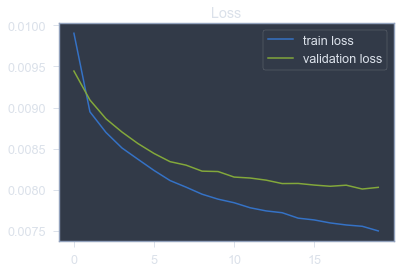

In [7]:
# Define the number of features
max_features = train.shape[1]

# Define the encoder dimension
encoding_dim = 128

# Input Layer
input_dim = keras.Input(shape = (max_features, ))

# Encoder Layers
noise = keras.layers.Dropout(0.5)(input_dim) # for Denoising
encoded1 = keras.layers.Dense(512, activation = 'relu', kernel_initializer= he_avg_init)(noise)
encoded2 = keras.layers.Dense(256, activation = 'relu', kernel_initializer= he_avg_init)(encoded1)
encoded3 = keras.layers.Dense(128, activation = 'relu', kernel_initializer= he_avg_init)(encoded2)
encoded4 = keras.layers.Dense(encoding_dim, activation = 'relu', kernel_initializer= he_avg_init)(encoded3)

# Decoder Layers
decoded1 = keras.layers.Dense(128, activation = 'elu')(encoded4)
decoded2 = keras.layers.Dense(256, activation = 'elu')(decoded1)
decoded3 = keras.layers.Dense(512, activation = 'elu')(decoded2)
decoded4 = keras.layers.Dense(max_features, activation = 'linear')(decoded3)

# Combine Encoder and Deocder layers
autoencoder = keras.Model(inputs = input_dim, outputs = decoded4)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer=keras.optimizers.Adam(lr=0.001, decay=1e-8), loss = 'mse')

# Train the model
history = autoencoder.fit(train, train, epochs=20, batch_size=64, 
                          shuffle=True, validation_data=(test,test))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [8]:
# Use a middle Bottleneck Layer to Reduce Dimension
hidden_act = [encoded4]
for ix, act in enumerate(hidden_act):
    model = keras.Model(inputs=input_dim, outputs=act)
    if ix == 0: 
        X_train = model.predict(train)
        X_test = model.predict(test)
    else:
        X_train = np.hstack([X_train, model.predict(train)])
        X_test = np.hstack([X_test, model.predict(test)])
        
X_train.shape, X_test.shape

((3500, 128), (2482, 128))

### Build Models

In [9]:
# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
input = keras.Input(shape = (max_features, ))
x = keras.layers.Dense(32, activation='elu', kernel_initializer="he_normal")(input)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(16, activation='elu', kernel_initializer="he_normal")(input)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(8, activation='elu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input, outputs=output)
model.summary()
#Image(keras.utils.model_to_dot(model,show_shapes=True,show_layer_names=False, dpi=100) \
#      .create(prog='dot', format='png'))

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
____________________________________________________

In [10]:
# Train the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=200, batch_size=64, 
                    validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
44/44 [==============================] - 0s 6ms/step - loss: 0.7008 - acc: 0.5686 - val_loss: 0.6618 - val_acc: 0.6229
Epoch 2/200
44/44 [==============================] - 0s 4ms/step - loss: 0.6646 - acc: 0.6000 - val_loss: 0.6502 - val_acc: 0.6257
Epoch 3/200
44/44 [==============================] - 0s 3ms/step - loss: 0.6533 - acc: 0.6086 - val_loss: 0.6387 - val_acc: 0.6257
Epoch 4/200
44/44 [==============================] - 0s 3ms/step - loss: 0.6451 - acc: 0.6296 - val_loss: 0.6290 - val_acc: 0.6700
Epoch 5/200
44/44 [==============================] - 0s 3ms/step - loss: 0.6332 - acc: 0.6436 - val_loss: 0.6181 - val_acc: 0.6600
Epoch 6/200
44/44 [==============================] - 0s 3ms/step - loss: 0.6196 - acc: 0.6561 - val_loss: 0.6083 - val_acc: 0.6871
Epoch 7/200
44/44 [==============================] - 0s 3ms/step - loss: 0.6135 - acc: 0.6714 - val_loss: 0.5997 - val_acc: 0.6843
Epoch 8/200
44/44 [==============================] - 0s 3ms/step - loss: 0.6110 - a

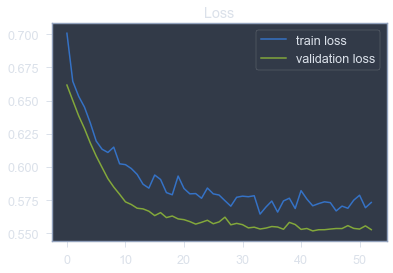

In [11]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

### Make Submissions

In [13]:
pred = model.predict(X_test).flatten()
t = pd.Timestamp.now()
fname = f"AE_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'AE_submission_12151447.csv' is ready to submit.


<font color='blue'><p>
### 추가 고려사항
- Denoising Autoencoder (DAE)가 더 성능이 좋다고 알려져 있음 
- DAE 구현방식         
<img align='left' src='https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile24.uf.tistory.com%2Fimage%2F992860505BDC99320A2AA2'>  

<font color='tomato'><font color="#CC3D3D"><p>
# End